In [1]:
import os, shutil, sys, time, re, glob, csv, random
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import dlib

# Dlib face detector
detector = dlib.get_frontal_face_detector()

# Facial landmarks detector
predictor = dlib.shape_predictor('../shape_predictor_68_face_landmarks.dat')

In [2]:
# Get images, labels tuple for CK+ datset
def importCKPlusDataset(dir = 'CKPlus', categories = None, includeNeutral = False, contemptAs = None):

    # Note: "Neutral" is not labeled in the CK+ dataset
    categoriesCK = ['Angry', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']

    if categories is None:
        categoriesEitW = [ 'Angry' , 'Disgust' , 'Fear' , 'Happy'  , 'Neutral' ,  'Sad' , 'Surprise']
    else:
        categoriesEitW = categories

    # Root directories for images and labels. Should have no other .txt or .png files present
    dirImages = dir + '/CKPlus_Images'
    dirLabels = dir + '/CKPlus_Labels'

    if contemptAs is not None:
        # Verify a valid string was supplied
        try:
            ind = categoriesEitW.index(contemptAs)
        except ValueError:
            raise ValueError("\nError in importCKPlusDataset(): contemptAs = '" + contemptAs + "' is not a valid category. Exiting.\n")

    # Get all possible label and image filenames
    imageFiles = glob.glob(dirImages + '/*/*/*.png')
    labelFiles = glob.glob(dirLabels + '/*/*/*.txt')

    # Get list of all labeled images:
    # Convert label filenames to image filenames
    # Label looks like: CK_Plus/CKPlus_Labels/S005/001/S005_001_00000011_emotion.txt
    # Image looks like: CK_Plus/CKPlus_Images/S005/001/S005_001_00000011.png
    allLabeledImages = []

    for label in labelFiles:
        img = label.replace(dirLabels,dirImages)
        img = img.replace('_emotion.txt','.png')
        allLabeledImages.append(img)

    # Construct final set of labeled image file names and corresponding labels
    # Be sure not to include images labeled as "contempt", since those are not part of our vocabulary
    labeledImages = []
    labels = []
    labelNames = []
    contemptImages = []
    for ind in range(len(labelFiles)):
        curLabel = labelFiles[ind]
        curImage = allLabeledImages[ind]

        # Open the image as binary read-only
        with open(curLabel, 'rb') as csvfile:

            # Convert filestream to csv-reading filestream
            rd = csv.reader(csvfile)
            str = rd.next()

            # Get integer label in CK+ format
            numCK = int(float(str[0]))

            # Get text label from CK+ number
            labelText = categoriesCK[numCK-1]

            if labelText != 'Contempt':
                numEitW = categoriesEitW.index(labelText)
                labeledImages.append(curImage)
                labels.append(numEitW)
                labelNames.append(labelText)
            elif contemptAs is not None:
                # Lump "Contempt" in with another category
                numEitW = categoriesEitW.index(contemptAs)
                labeledImages.append(curImage)
                labels.append(numEitW)
                labelNames.append(labelText)
            else:
                # Discard "Contempt" image
                contemptImages.append(curImage)

    images = labeledImages

    # For testing only:
    #images = images[0:10]
    #labels = labels[0:10]

    return images, labels #, labelNames

# Get entire dataset
# Inputs: Dataset root directory; optional dataset name
# Returns: List of all image file paths; list of correct labels for each image
def importDataset(dir, dataset, categories):
    imgList = glob.glob(dir+'/*')
    labels = None

    # Datset-specific import rules:
    if dataset.lower() == 'jaffe' or dataset.lower() == 'training':
        # Get Jaffe labels
        jaffe_categories_map = {
            'HA': categories.index('Happy'),
            'SA': categories.index('Sad'),
            'AN': categories.index('Angry'),
            'FE': categories.index('Fear'),
            'DI': categories.index('Disgust'),
            'SU': categories.index('Surprise')
            }

        labels = []

        for img in imgList:
            if os.path.isdir(img):
                continue
            key = img.split('.')[3][0:2]
            if (key in jaffe_categories_map):
                labels.append(jaffe_categories_map[key])

    elif dataset.lower() == 'ckplus':
        # Pathnames and labels for all images
        imgList, labels = importCKPlusDataset(dir, categories=categories, contemptAs=None)

    elif dataset.lower() == 'misc':
        labels = [0,1,2,3,4,5,6]

    else:
        print 'Error - Unsupported dataset: ' + dataset
        return None

    # Make sure some dataset was imported
    if len(imgList) <= 0:
        print 'Error - No images found in ' + str(dir)
        return None

    # Return list of filenames
    return imgList, labels

In [3]:
categories = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']

images, labels = importDataset('../data/CKPlus/', 'ckplus', categories=categories)

image_labels = zip(images, labels)
random.shuffle(image_labels)
print([x[1] for x in image_labels])

# 0 - angry
# 1 - disgust
# 2 - Happy
# 3 - neutral
# 4 - sad
# 5 - surprise

[3, 1, 3, 3, 3, 4, 5, 0, 0, 4, 0, 2, 3, 2, 5, 1, 1, 5, 4, 1, 2, 1, 3, 3, 1, 1, 5, 3, 3, 5, 3, 5, 0, 5, 5, 5, 3, 1, 5, 3, 5, 0, 5, 2, 3, 4, 1, 3, 5, 3, 1, 3, 4, 1, 0, 0, 3, 0, 3, 0, 1, 5, 4, 4, 5, 3, 0, 3, 0, 3, 0, 1, 3, 5, 5, 3, 2, 4, 2, 1, 3, 3, 3, 0, 3, 1, 5, 5, 5, 4, 3, 2, 4, 3, 3, 2, 3, 4, 1, 3, 0, 3, 5, 5, 1, 3, 4, 3, 5, 1, 5, 3, 5, 5, 1, 5, 5, 3, 5, 1, 5, 5, 0, 0, 1, 3, 2, 2, 3, 5, 3, 5, 4, 5, 0, 0, 1, 5, 5, 3, 0, 5, 4, 2, 5, 2, 1, 5, 1, 1, 1, 5, 5, 5, 1, 0, 3, 0, 2, 3, 5, 5, 5, 5, 5, 0, 0, 4, 5, 5, 4, 4, 3, 5, 1, 5, 5, 2, 4, 0, 1, 4, 3, 5, 3, 0, 5, 4, 4, 5, 4, 3, 1, 5, 1, 2, 3, 0, 3, 0, 2, 1, 3, 5, 5, 0, 0, 4, 3, 5, 1, 4, 1, 4, 1, 0, 1, 2, 2, 0, 5, 1, 3, 1, 1, 5, 2, 3, 1, 1, 3, 2, 3, 5, 3, 1, 0, 3, 4, 1, 2, 5, 1, 5, 5, 1, 5, 3, 5, 5, 1, 1, 1, 3, 0, 0, 5, 5, 5, 3, 0, 3, 1, 5, 1, 3, 1, 5, 5, 2, 3, 1, 0, 5, 2, 2, 0, 3, 5, 3, 0, 3, 0, 3, 1, 4, 3, 5, 0, 5, 5, 1, 4, 0, 5, 1, 5, 1, 0, 0, 0, 1, 2, 5, 0, 1, 3, 1, 5]


In [4]:
def get_landmarks(_image):
    """
    takes in an image, detects face in it,
    if face is detected then finds facial landmarks of that face,
    extracts some features as explained in code
    return : list of features corresponding to the detected face,
             if no face is detected, returns "error"
    """
    image = _image.copy()
    detections = detector(image, 1)
    
    # for all detected face instances individually
    for k, d in enumerate(detections):
        
        # get Facial Landmarks with the predictor class
        shape = predictor(image, d)
        
        xlist = []
        ylist = []
        # store X and Y coordinates in two lists
        for i in range(1, 68):
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
                
        xmean = xlist[29]
        ymean = ylist[29]
        
        # get distance between each point and the central point in both axes
        xcentral = [(x - xmean) for x in xlist]
        ycentral = [(y - ymean) for y in ylist]
        
        # point 29 - nose tip
        # point 26 - middle point b/w two eyes
        
        # get angle that nose line makes with vertical, this for correcting tilted faces.
        angle_nose = np.arctan2((ylist[26] - ymean), (xlist[26] - xmean)) * 180 / np.pi
        if angle_nose < 0:
            angle_nose += 90
        else:
            angle_nose -= 90
        
        # landmarks_vectorised is the feature vector corresponding to the face
        """
        landmarks_vectorised is of the form
        [p1_x_rel, p1_y_rel, dist(p, centre), angle()]
        """
        landmarks_vectorised = []
        for i in range(0, 67):
            """
            rx - x coordinate of relative position of a point w.r.t central point
            ry - y coordinate of relative position of a point w.r.t central point
            x - absolute x coordinate
            y - absolute y coordinate
            """
            
            rx = xcentral[i]
            ry = ycentral[i]
            x = xlist[i]
            y = ylist[i]
        
            landmarks_vectorised.append(rx)
            landmarks_vectorised.append(ry)

            # calculate length of point i from central point
            dist = np.linalg.norm(np.array([rx, ry]))
            landmarks_vectorised.append(dist)

            # get the angle the vector describes relative to the image, 
            # corrected for the offset that the nosebrigde has when the face is titled
            anglerelative = (np.arctan2((-ry), (-rx)) * 180 / np.pi) - angle_nose
            landmarks_vectorised.append(anglerelative)
        
    if len(detections) < 1: 
        landmarks_vectorised = "error"     
    
    return landmarks_vectorised
        


def make_sets():
    """
    return: creates feature matrix by appending feature vector of 
            each image.
    """
    train_data = []
    test_data = []
    train_label = []
    test_label = []
    
    start_time = time.time()
    
    # take first 80 % of the images for training and rest for testing
    train_image_labels = image_labels[:int(len(image_labels)*0.8)]
    test_image_labels = image_labels[-int(len(image_labels)*0.2):]
    
    for item in train_image_labels:
        
        # open image
        image = cv.imread(item[0]) 
        
        # convert to grayscale
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        clahe_image = clahe.apply(gray)
        
        # get feature vector
        landmarks_vectorised = get_landmarks(clahe_image)
        
        if landmarks_vectorised == "error":
            print("no face")
        else:
            train_data.append(landmarks_vectorised)
            train_label.append(item[1])
            
    print('train - ', time.time() - start_time)
    
    for item in test_image_labels:
        image = cv.imread(item[0])
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        clahe_image = clahe.apply(gray)
  
        landmarks_vectorised = get_landmarks(clahe_image)
        if landmarks_vectorised == "error":
            pass
        else:
            test_data.append(landmarks_vectorised)
            test_label.append(item[1])
        
    print('test - ', time.time() - start_time)

    return train_data, test_data, train_label, test_label


def plot_confusion_matrix(cm, classes=categories,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
import time

start_time = time.time()
train_data, test_data, training_label, test_label = make_sets()
print('feature extraction done in %f sec' % (time.time() - start_time))

('train - ', 38.63363003730774)
('test - ', 49.67873191833496)
feature extraction done in 49.679497 sec


In [6]:
print(len(train_data), len(test_data))

(247, 61)


MLP classifier fit done in 1.324379 sec
MLP clf prediction done in 0.004191 sec
Training accuracy (using MLP) - 77.049180 
Confusion matrix of prediction using MLP classifier
[[ 7  2  0  1  3  0]
 [ 2 11  0  0  0  1]
 [ 0  0  3  1  0  0]
 [ 1  0  0 10  0  0]
 [ 1  0  0  0  1  0]
 [ 0  2  0  0  0 15]]


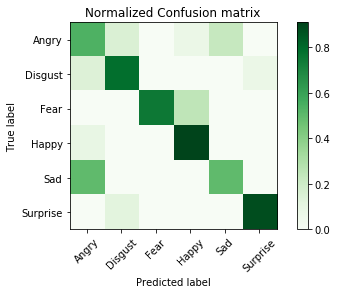

In [8]:
##### Multilayer Perceptron Classifier

from sklearn.neural_network import MLPClassifier
import joblib
from sklearn.metrics import confusion_matrix

train_net = True
model_path_MLP = 'trained_models/MLP_20_30_30_clf_CK_temp.pkl'

if train_net:
    # training
    start_time = time.time()
    nn_clf = MLPClassifier(solver='lbfgs', alpha=1e-6, hidden_layer_sizes=(20, 30, 30), random_state=1, max_iter=1000)
    nn_clf.fit(train_data, training_label)
    print('MLP classifier fit done in %f sec' % (time.time() - start_time))
    
    # save model
    joblib.dump(nn_clf, model_path_MLP, compress=9)

## prediction
start_time = time.time()
nn_clf = joblib.load(model_path_MLP)
nn_predicted_labels = nn_clf.predict(test_data)
print('MLP clf prediction done in %f sec' % (time.time() - start_time))
print('Training accuracy (using MLP) - %f ' % (np.mean(nn_predicted_labels == test_label) * 100))

cm = confusion_matrix(test_label, nn_predicted_labels)
print('Confusion matrix of prediction using MLP classifier')
print(cm)
plot_confusion_matrix(cm)    
plt.show()

training XGB classifier..
XGB classifier fit done in 2.209326 sec
starting XGB prediction..
XGB prediction done in 0.011025 sec
Training accuracy (using XGB) - 78.688525
Confusion matrix of prediction using MLP classifier
[[ 7  2  1  2  1  0]
 [ 3 11  0  0  0  0]
 [ 0  0  3  0  0  1]
 [ 0  0  1 10  0  0]
 [ 2  0  0  0  0  0]
 [ 0  0  0  0  0 17]]


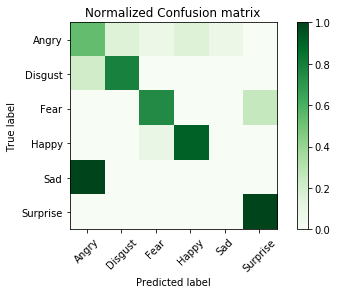

In [10]:
from xgboost import XGBClassifier

train_XGB = True
model_path_XGB = 'trained_models/XGB_temp.pkl'

train_data = np.asarray(train_data)
training_label = np.asarray(training_label)

test_data = np.asarray(test_data)
test_label = np.asarray(test_label)

if train_XGB:
    # training
    # training
    start_time = time.time()
    xgb_clf = XGBClassifier()
    print('training XGB classifier..')
    xgb_clf.fit(train_data, training_label)
    print('XGB classifier fit done in %f sec' % (time.time() - start_time))
    
    # save model
    joblib.dump(xgb_clf, model_path_XGB, compress=9)
    
# prediction
start_time = time.time()
xgb_clf = joblib.load(model_path_XGB)
print('starting XGB prediction..')
xgb_predicted_labels = xgb_clf.predict(test_data)
print('XGB prediction done in %f sec' % (time.time() - start_time))

print('Training accuracy (using XGB) - %f' % (np.mean(xgb_predicted_labels == test_label) * 100))

cm = confusion_matrix(test_label, xgb_predicted_labels)
print('Confusion matrix of prediction using MLP classifier')
print(cm)
plot_confusion_matrix(cm)    
plt.show()

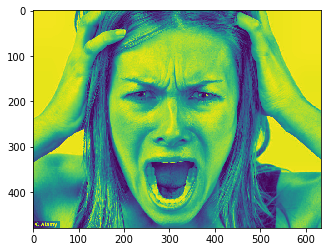

Disgust


,Angry,Disgust,Fear,Happy,Sad,Surprise
0,7.068508e-61,1.0,1.077202e-151,2.017525e-46,1.139207e-140,1.492832e-65


In [15]:
### external test
image = cv.imread('test_images/face.jpg')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_image = clahe.apply(gray)

plt.imshow(clahe_image)
plt.show()

landmarks_vectorised = get_landmarks(clahe_image)

nn_clf = joblib.load(model_path_MLP)
nn_predicted_labels = nn_clf.predict([landmarks_vectorised])

print(categories[nn_predicted_labels[0]])
pd.DataFrame(nn_clf.predict_proba([landmarks_vectorised]), columns=categories)

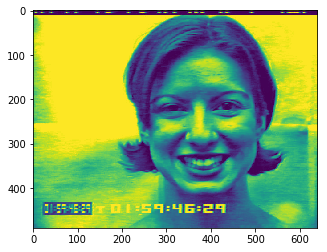

Happy


,0,1,2,3,4,5
0,5.946766e-98,7.470530e-77,1.964582e-69,1.0,2.131579e-88,2.314905e-85


In [116]:
### external test
image = cv.imread(images[3])
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_image = clahe.apply(gray)

plt.imshow(clahe_image)
plt.show()

landmarks_vectorised = get_landmarks(clahe_image)


nn_clf = joblib.load(model_path_MLP)
nn_predicted_labels = nn_clf.predict([landmarks_vectorised])

print(categories[nn_predicted_labels[0]])
pd.DataFrame(nn_clf.predict_proba([landmarks_vectorised]))

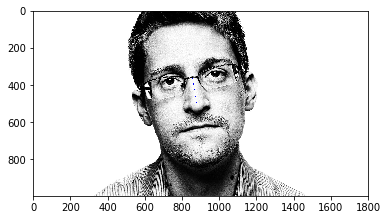

True

In [130]:
# while True:
frame = cv.imread("angle-face.jpg")

gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_image = clahe.apply(gray)

detections = detector(clahe_image, 1) #Detect the faces imagn the image
# detections - dlib.rectangles
# print(type(detections))

for k,d in enumerate(detections): #For each detected face
    shape = predictor(clahe_image, d) #Get coordinates
    cv.line(frame, (shape.part(30).x, shape.part(30).y), (shape.part(27).x, shape.part(27).y), (0, 0, 255))
    
cv.line(frame, (shape.part(30).x, shape.part(30).y), (shape.part(30).x, shape.part(27).y), (0, 0, 255))
        
plt.imshow(frame)
plt.show()

cv.imwrite('new-angle.png', frame)